## Group Project Report: Predicting Heart Disease Using knn classification
Nethkini Liyanage - Charlotte Du - Andrew Young Liu - Vivian Khong

In [1]:
#load packages
library(tidyverse)
library(tidymodels)
library(dplyr)
library(gridExtra)

# set the seed
set.seed(1)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Introduction:
Each year, approximately 1 in 5 deaths in America are caused by heart disease. From a more global perspective, about 18 million deaths are caused by heart disease. Factors including cholesterol, blood pressure, and blood sugar levels, among many others, are critical indicators of heart disease risk and contribute to narrowing arteries and reducing blood flow to the heart. This ultimately increases the chances of heart attacks and other cardiovascular complications. Finding early indicators and symptoms of heart disease can contribute to reducing death rates caused by heart disease as preventative care methods can be implemented. Screening for heart disease symptoms with currently available medical technology such as ECGs, MRIs and X-rays can be quite costly and inaccessible for certain patients globally. With a goal of constructing a more accessible method to predict heart disease, this project will utilize publicly available data to build a model that can predict if a patient has or does not have heart disease. The dataset used in this project is the “Heart Disease” dataset donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach California in 1988 which includes 14 attributes and a target variable indicating the presence or absence of heart disease. The dataset contains data from patient test groups from Switzerland, America, and Hungary. This project focuses on the database from Cleveland, Ohio to determine if cases of heart disease can be accurately classified using  three main variables including maximum heart rate achieved during exercise (thalach), ST depression induced by exercise relative to rest (oldpeak), and number of major vessels coloured by flouroscopy (ca). 

## Methods & Results

### Loading Data into R

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# create readable column name tibble
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "heart_disease_presence")
# read the data into R
cleveland_data <- read.csv(url, header = FALSE, col.names = column_names)

# view the first few rows of the data and have a glipmse
head(cleveland_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### Cleaning and Wrangling data

#### Convert data types

In [3]:
# convert 0 to 'no' and 1-3 to 'yes' for heart_disease_presence column
cleveland_data$heart_disease_presence <- ifelse(cleveland_data$heart_disease_presence == 0, 'no', 'yes')

# convert the column types of ca and heart_disease_presence
cleveland_data <- mutate(cleveland_data, ca = as.numeric(ca), 
    heart_disease_presence = as.factor(heart_disease_presence))

# see first 6 rows to check the effect
head(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion”


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,no
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,yes
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,yes
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,no
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,no
6,56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,no


#### Count the numer of rows having missing data then filter them out

In [4]:
# summarize the number of observations that are "NA"
cleveland_data |>
  summarise(
    na_count = sum(rowSums(is.na(cleveland_data)))
  )

na_count
<dbl>
4


Table 1

In [5]:
# delete these rows
cleveland_data <- na.omit(cleveland_data)

In [6]:
# summarize the number of observations that are "?"
question_mark__count <- data.frame(t(colSums(cleveland_data == "?")))
question_mark__count

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,2,0


Table 2

In [7]:
# delete rows with "?"
cleveland_data <- filter(cleveland_data, thal != "?")

### Data Split

In [8]:
# split the data to 75% training and 25% testing
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = heart_disease_presence)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

# show the head of the training data
head(cleveland_train)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,no
2,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,no
3,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,no
4,57,1,4,140,192,0,0,148,0,0.4,2,0,6.0,no
5,56,0,2,140,294,0,2,153,0,1.3,2,0,3.0,no
6,57,1,3,150,168,0,0,174,0,1.6,1,0,3.0,no


### Summary Tables of Class Distribution of Training Data

In [9]:
# Summary table with count of observations, mean of potential predictors
summary_table <- cleveland_train |>
  summarise(
    Count_Yes = sum(heart_disease_presence == "yes"),
    Count_No = sum(heart_disease_presence == "no"),
    Mean_trestbps = mean(trestbps),
    Mean_thalach = mean(thalach),
    Mean_oldpeak = mean(oldpeak),
    Mean_chol = mean(chol),
    Mean_ca = mean(ca),
  )
summary_table

Count_Yes,Count_No,Mean_trestbps,Mean_thalach,Mean_oldpeak,Mean_chol,Mean_ca
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102,120,132.3604,149.6216,1.058108,246.8649,0.6666667


Table 3

### Visualizations of Potential Predictor Variables

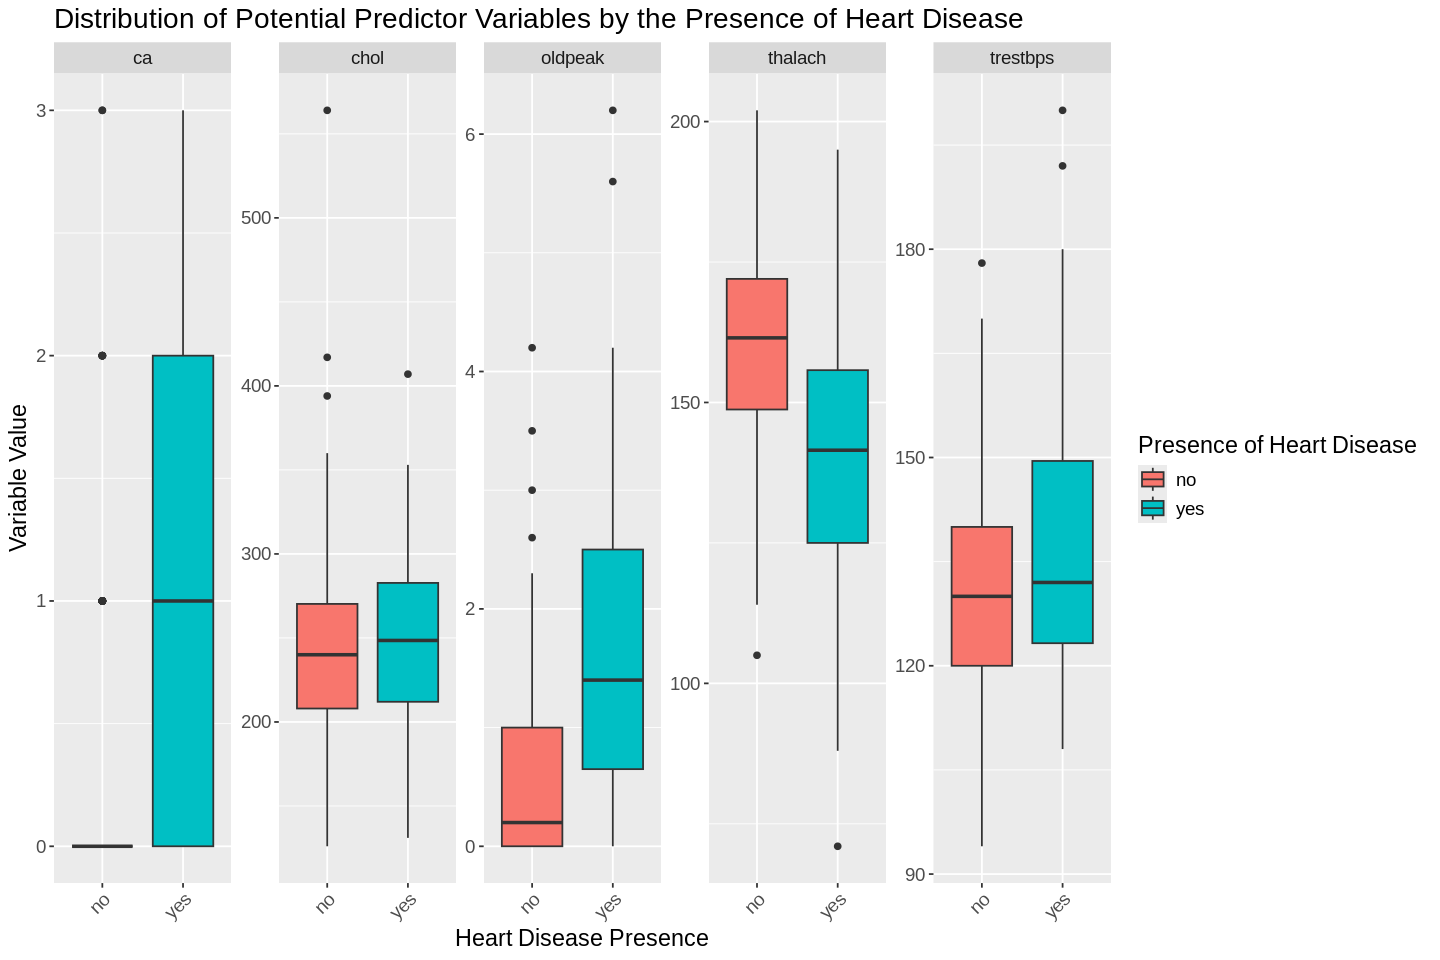

In [10]:
# box plots visualization of the data
options(repr.plot.width=12, repr.plot.height=8)

long_data <- cleveland_train |>
  pivot_longer(cols = c(trestbps, thalach, oldpeak, chol, ca), names_to = "variable", values_to = "value")

ggplot(long_data, aes(x = heart_disease_presence, y = value, fill = heart_disease_presence)) +
  geom_boxplot() +
  facet_wrap(~variable, scales = 'free', ncol = 5) +
  labs(x = "Heart Disease Presence", y = "Variable Value", fill = "Presence of Heart Disease", title = "Distribution of Potential Predictor Variables by the Presence of Heart Disease") +
  theme(text = element_text(size = 14), axis.text.x = element_text(angle = 45, hjust = 1))

Figure 1

### Classification Data Analysis

#### Predictors Selection and its Reasoning

By observing the above boxplots side by side, we decided that the variables 'ca,' 'oldpeak,' and 'thalach' should be selected as predictors for our analysis, as they exhibit statistically significant variation in the boxplot when comparing different categories of heart condition presence and are unlikely due to sampling variability.

#### Preprocess the Data

In [11]:
# scale and center training data
cleveland_recipe <- recipe(heart_disease_presence ~ ca + chol + oldpeak, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#### Tuning the Classifier

In [12]:
# create K-nearest neighbor model specification with tune
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# 5-fold cross-validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = heart_disease_presence)

# create a Ks' data frame from 1 to 20
grid_vals <- tibble(neighbors = seq(1, 20))

# workflow analysis combines recipe and model
knn__results <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cleveland_vfold, grid = grid_vals) |>
  collect_metrics()

#### Print Accuracies for ALL Ks

In [13]:
accuracy_results <- knn__results |> 
  filter(.metric == "accuracy")
accuracy_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7117172,5,0.02052855,Preprocessor1_Model01
2,accuracy,binary,0.7252525,5,0.01281774,Preprocessor1_Model02
3,accuracy,binary,0.7253535,5,0.03117205,Preprocessor1_Model03
4,accuracy,binary,0.7253535,5,0.03117205,Preprocessor1_Model04
5,accuracy,binary,0.7747475,5,0.02367766,Preprocessor1_Model05
6,accuracy,binary,0.7747475,5,0.02367766,Preprocessor1_Model06
7,accuracy,binary,0.7705051,5,0.03091247,Preprocessor1_Model07
8,accuracy,binary,0.7705051,5,0.03091247,Preprocessor1_Model08
9,accuracy,binary,0.7389899,5,0.02844578,Preprocessor1_Model09


Table 4

#### Ploting the Accuracy vs k

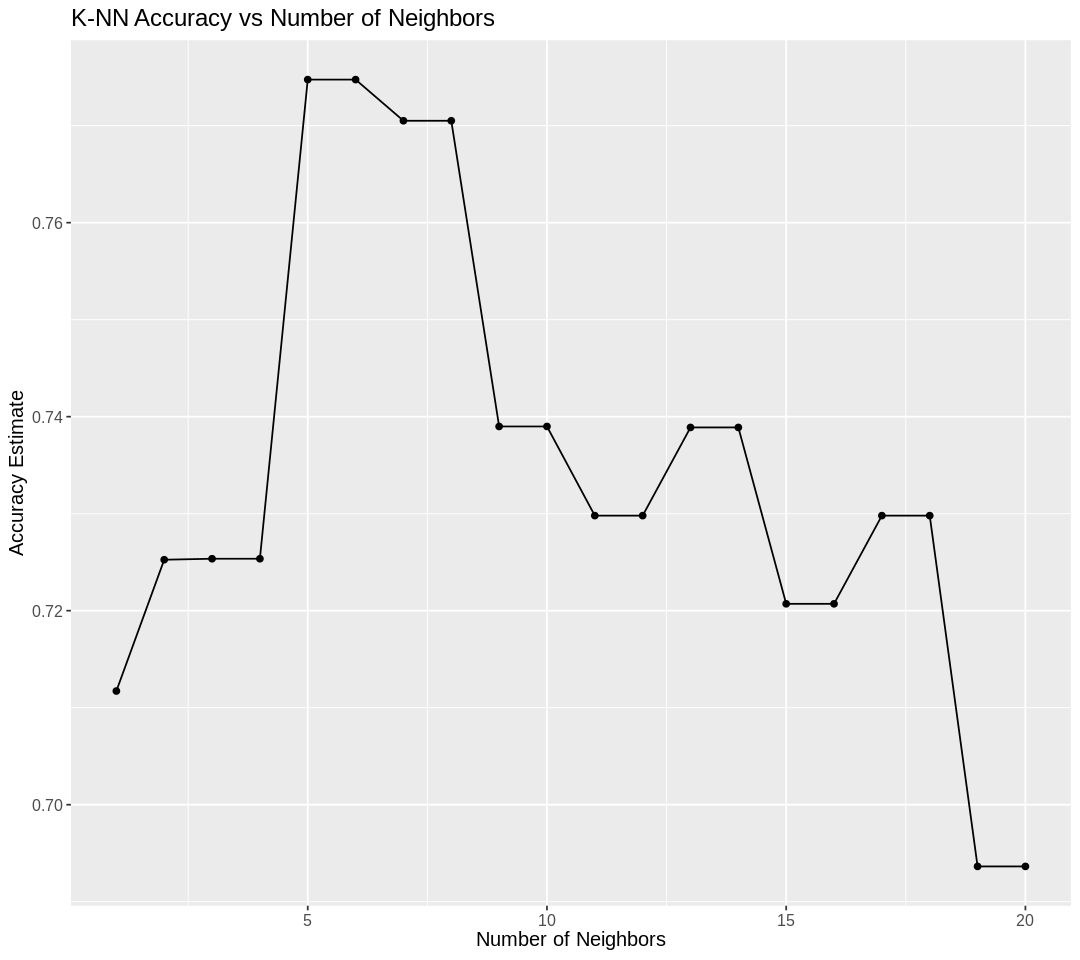

In [14]:
options(repr.plot.width= 9, repr.plot.height = 8)

accuracy_plot <- ggplot(accuracy_results, aes(x = neighbors, y = mean)) +
geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate", title = "K-NN Accuracy vs Number of Neighbors") +
  theme(text = element_text(size = 12))
accuracy_plot

Figure 2

#### Obtain the Number of Neighbours with the Highest Accuracy

In [15]:
best_k <- accuracy_results |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

[1] 5

#### Retrain the Classifier with the Best K

In [16]:
# reconstruct the model with the best k
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

best_k_recipe <- recipe(heart_disease_presence ~ ca + chol + oldpeak, data = cleveland_train) |>
     step_scale(all_predictors()) |>
    step_center(all_predictors())

best_knn_fit <- workflow() |>
  add_recipe(best_k_recipe) |>
  add_model(best_k_spec) |>
  fit(data = cleveland_train)

#### Predict Lables on the Testing Data

In [17]:
# predict the test set
cleveland_test_predictions <- predict(best_knn_fit, cleveland_test) |>
  bind_cols(cleveland_test)
head(cleveland_test_predictions)

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease_presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
no,56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,no
yes,62,0,4,140,268,0,2,160,0,3.6,3,2,3.0,yes
no,57,0,4,120,354,0,0,163,1,0.6,1,0,3.0,no
no,44,1,2,120,263,0,0,173,0,0.0,1,0,7.0,no
no,52,1,3,172,199,1,0,162,0,0.5,1,0,7.0,no
no,54,1,4,140,239,0,0,160,0,1.2,1,0,3.0,no


Table 5

### Evaluate the Performance

- Accuracy

In [18]:
cleveland_accuracy <- cleveland_test_predictions |>
    metrics(truth = heart_disease_presence, estimate = .pred_class) |>
    filter(.metric == "accuracy")
cleveland_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7866667


Table 6

- Check the order of the labels

In [19]:
# check the order of the labels in the heart_disease_presence variable
cleveland_test_predictions |> pull(heart_disease_presence) |> levels()

[1] "no"  "yes"

- Precision

In [20]:
# above result shows that "yes" is the second level so we specify the "positive" class corresponds to the second factor level thru event_level
cleveland_pre <- cleveland_test_predictions |>
  precision(truth = heart_disease_presence, estimate = .pred_class, event_level = "second")
cleveland_pre

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8518519


Table 7

- Recall

In [21]:
cleveland_re <- cleveland_test_predictions |>
  recall(truth = heart_disease_presence, estimate = .pred_class, event_level = "second")
cleveland_re

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6571429


Table 8

- Confusion Matrix

In [22]:
cleveland_con <- cleveland_test_predictions |>
  conf_mat(truth = heart_disease_presence, estimate = .pred_class)
cleveland_con

          Truth
Prediction no yes
       no  36  12
       yes  4  23

Table 9

### Visualization of the Analysis

In Table 6, we see that our classfier identified 23 out of 35 heart disease presence, and 36 out of 40 non-heart disease presence.

In [23]:
# calculate the percentage of our classifier correctly predict a positive label and a negative respectively
recall_for_positive_percent <- 23 / (12 + 23)
recall_for_negative_percent <- 36 / (36 + 4) 

# Create a data frame with the percentages
percentages_df <- data.frame(
  Category = c("Recall for Positive", "Recall for Negative"),
  Percentage = c(recall_for_positive_percent, recall_for_negative_percent)
)
percentages_df

Category,Percentage
<chr>,<dbl>
Recall_for_Positive,0.6571429
Recall_for_Negative,0.9000000


Table 10

We plot the above table in a bar graph.

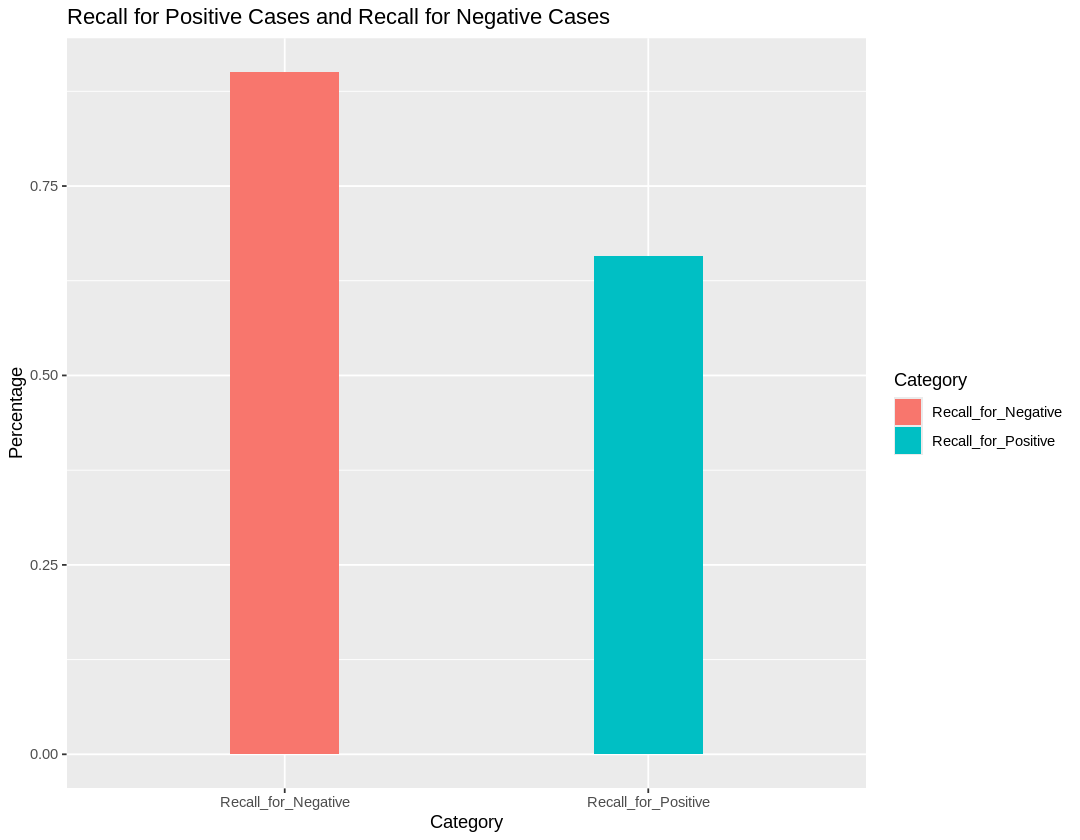

In [24]:
# Create a bar plot
options(repr.plot.width= 9, repr.plot.height = 7)
ggplot(percentages_df, aes(x = Category, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity", width = 0.3) +
  labs(title = "Recall for Positive Cases and Recall for Negative Cases", y = "Percentage")

Figure 3

## Discussion  

The purpose of this project was to predict the presence of heart disease in a patient. Using a K-nearest neighbor classification algorithm trained on publicly available heart disease data, we were able to build a model that can predict the presence of heart disease based on predictor observations that are easy and accessible to collect in a medical context. 

The model demonstrated an accuracy of 0.7867 which indicates that this model correctly predicts the presence or absence of heart disease for approximately 78.67% of the cases in our dataset. Further, a precision of 0.8519 means that when this model predicts a patient has heart disease, it is correct about 85.19% of the time. Additionally, a recall of 0.6571 means that our model correctly identifies 65.71% of the patients who actually have heart disease. 

Overall, this model shows decent ability to predict the presence of heart disease. However, there is much room for improvement in the model. In the Confusion Matrix (Table 9), it can be seen that the model makes many false negative predictions. Of 35 positive cases of heart disease, 12 were predicted to be negative. This can be disastrous as heart disease cases may be left untreated, allowing them to further develop over time. False positive predictions should also be kept in mind, as  unnecessary treatment can be costly and dangerous to patients. From these observations, future changes to the model should be made to reduce false negative predictions. 

These results generally align with what was expected to be found since we only used data from Cleveland, and only selected a few predictors. The accuracy, precision, and recall scores are decent scores for the first iteration of a model. With future improvements to the model, these scores would become more promising.

The findings of this model have several implications including clinical utility, patient care, and an overall positive impact on public health. This model can be used as a preliminary diagnostic tool, quickly ruling out cases of heart disease so doctors can focus on the more advanced side of diagnostics. This also saves money and resources, as it reduces unecessary use of equipment for diagnosis. Additionally, it could function as a crude tool for hospitals that may not have the resources for MRIs, X-rays, ECGs, etc. Patients also benefit; doing fewer tests lead to fewer medical expenses. Overall, there is positive impact on global health as faster diagnoses lead to faster implementation of treatment, which will ultimately decrease death rates.

The findings of this model opens doors to many areas of improvement, expansion, and additional questions. About the improvement of the model, we can ask, "What changes can we make to our predictors to improve the model?", or "How can we further optimize the K-nearest neighbours algorithm parameters to improve model performance?". Further on, we can also conduct studies to explore a variety of questions including how the variability between sexes may affect the model, how the model performs with data from places beyond Cleveland, and longitudinal studies to assess the model's performance over time. 

## References
1. Heart Disease Dataset UCI Machine Learning Repository. (n.d.). Retrieved from https://archive.ics.uci.edu/dataset/45/heart+disease
2. Heart Disease - Symptoms and Causes - Mayo Clinic. (2022, August 25). Retrieved from https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118#:~:text=Heart%20disease%20describes%20a%20range,born%20with%20(congenital%20heart%20defects)
3. Heart disease and stroke prevention. (n.d.). Retrieved from https://www.health.ny.gov/diseases/cardiovascular/heart_disease/#:~:text=About%20695%2C000%20people%20die%20of,Americans%20have%20a%20heart%20attack.